In [1]:
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from torchsummary import summary
import random
from train import *
from data_processing import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_path = './data/train/'
test_path = './data/test/'

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# CREATE DATA

In [2]:
labels = pd.read_csv('data/train_labels.csv')
labels = labels.set_index('id')

In [3]:
data = create_dataset(labels, train_path)

In [4]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

# FEATURES EXTRACTION

In [200]:
model_conv = torchvision.models.alexnet(weights='IMAGENET1K_V1')
model_conv.eval()

for param in model_conv.parameters():
    param.requires_grad = False

# remove last layer which is the classifier to only get the features
model_conv.classifier = nn.Identity()

features_list = []
for img in img_tensor_list:
    features_list.append(model_conv(img))

In [201]:
features_list

[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5391, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4920],
         [0.0000, 0.0000, 0.0000,  ..., 0.8796, 0.8796, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1654],
         [0.0000, 0.0000, 0.0000,  ..., 0.0180, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 1.0505, 4.2182,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

# TRAIN MODEL
Train model that predict all the labels

In [5]:
model = torchvision.models.alexnet(weights='IMAGENET1K_V1')

# freeze all parameters (except classification layer)
for param in model.parameters():
    param.requires_grad = False

# replace last layer by classifier with 17 outputs (all possible labels)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 16)

model = model.to(device)

criterion = nn.MSELoss()

# only optimise last layer (classifier)
optimizer_conv = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [6]:
model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6603
train Accuracy: 0.5605
train F1-score: 0.2612
val Loss: 0.5787
val Accuracy: 0.6000
val F1-score: 0.3455
Epoch 1/9
----------


KeyboardInterrupt: 

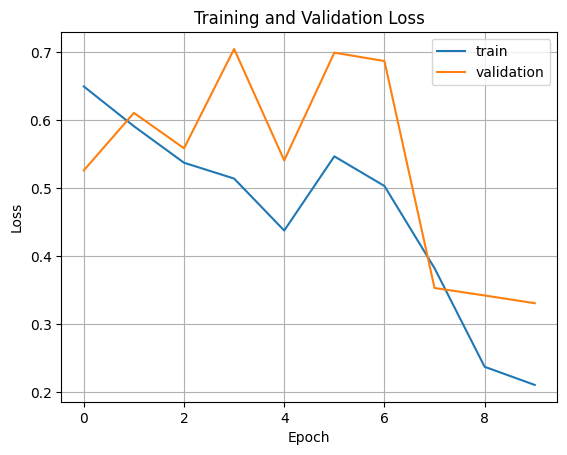

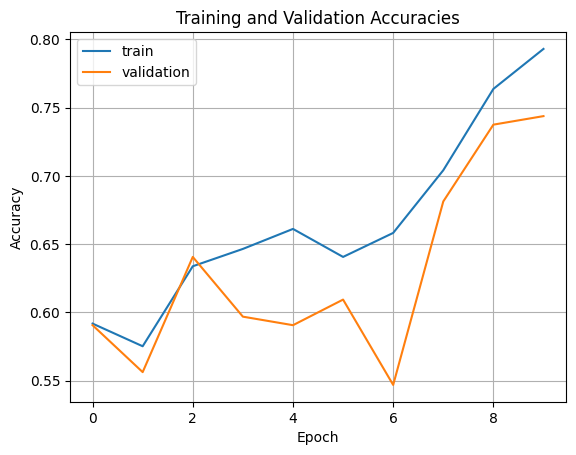

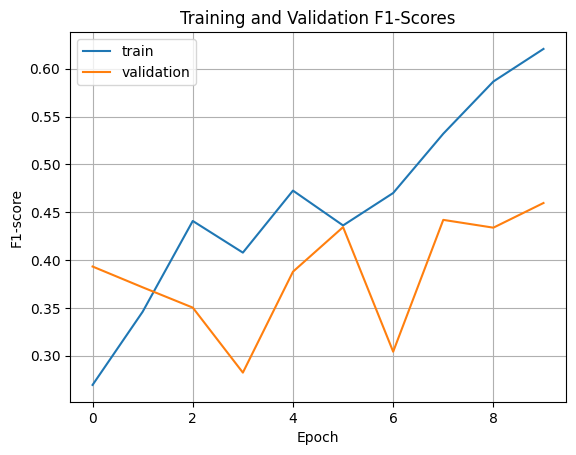

In [208]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(train_f1, label='train')
plt.plot(val_f1, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation F1-Scores')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.show()

In [ ]:
summary(model, (3, 224, 224))

# TRAIN EUR/CHF/OOD CLASSIFIER
Train a model that classifies how many franc, euros and ood are in the image

In [6]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [7]:
# first process labels to have the number of franc/euro/ood instead of the number of each coin
labels = pd.read_csv('data/train_labels.csv')
labels = labels.set_index('id')
labels['n_CHF'] = labels[['5CHF', '2CHF', '1CHF', '0.5CHF', '0.2CHF', '0.1CHF', '0.05CHF']].sum(axis=1)
labels['n_EUR'] = labels[['2EUR', '1EUR', '0.5EUR', '0.2EUR', '0.1EUR', '0.05EUR', '0.02EUR', '0.01EUR']].sum(axis=1)
labels = labels[['n_CHF', 'n_EUR', 'OOD']]
labels

,n_CHF,n_EUR,OOD
id,,,
L1010281,6,2,0
L1010298,5,0,0
L1010321,3,6,0
L1010310,3,4,0
L1010300,1,4,0
...,...,...,...
L1010524,1,1,1
L1010506,1,1,1
L1010521,1,1,1


In [ ]:
data = create_dataset(labels, train_path)

In [9]:
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

In [27]:
model_3classes = torchvision.models.alexnet(weights='IMAGENET1K_V1')

# freeze all parameters (except classification layer)
for param in model_3classes.parameters():
    param.requires_grad = False

# replace last layer by classifier with 3 outputs (all currencies)
num_ftrs = model_3classes.classifier[-1].in_features
model_3classes.classifier[-1] = nn.Linear(num_ftrs, 3)

model_3classes = model_3classes.to(device)

criterion = nn.MSELoss()

# only optimise last layer (classifier)
optimizer_conv = optim.SGD(model_3classes.classifier.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
model_3classes, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model_3classes, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=21, batch_size=6)

Epoch 0/20
----------
train Loss: 2.9704
train Accuracy: 0.2879
train F1-score: 0.5782
val Loss: 2.0297
val Accuracy: 0.2852
val F1-score: 0.7021
Epoch 1/20
----------
train Loss: 1.8964
train Accuracy: 0.3939
train F1-score: 0.6782
val Loss: 1.9620
val Accuracy: 0.4148
val F1-score: 0.7491
Epoch 2/20
----------
train Loss: 1.3041
train Accuracy: 0.4141
train F1-score: 0.7183
val Loss: 1.7920
val Accuracy: 0.4889
val F1-score: 0.7603
Epoch 3/20
----------
train Loss: 1.2989
train Accuracy: 0.4571
train F1-score: 0.7583
val Loss: 1.8190
val Accuracy: 0.5741
val F1-score: 0.7584
Epoch 4/20
----------
train Loss: 1.1013
train Accuracy: 0.4444
train F1-score: 0.7182
val Loss: 1.5246
val Accuracy: 0.5148
val F1-score: 0.8029
Epoch 5/20
----------
train Loss: 1.0839
train Accuracy: 0.5303
train F1-score: 0.7739
val Loss: 1.5324
val Accuracy: 0.5519
val F1-score: 0.8111
Epoch 6/20
----------
train Loss: 1.1924
train Accuracy: 0.4874
train F1-score: 0.7690
val Loss: 1.8989
val Accuracy: 0.3926

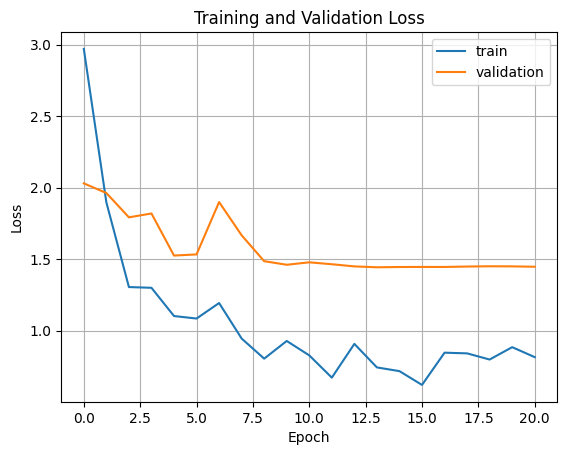

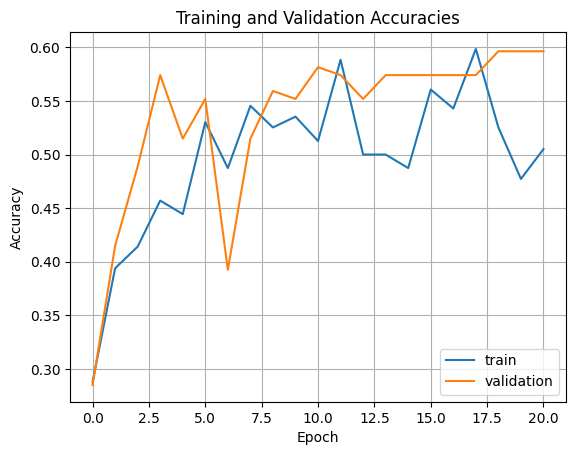

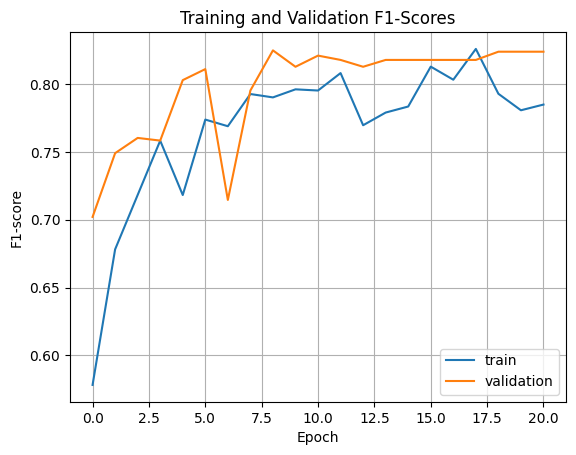

In [29]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(train_f1, label='train')
plt.plot(val_f1, label='validation')
plt.legend()
plt.grid()
plt.title('Training and Validation F1-Scores')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.show()

# TEST

In [14]:
labels = preds[1][0]
labels

tensor([[0., 8., 0.],
        [1., 0., 1.],
        [1., 2., 0.],
        [1., 1., 2.]])

In [15]:
print(preds[1][1])

tensor([[1., 2., 0.],
        [1., -0., 1.],
        [1., 1., 0.],
        [2., 1., 1.]])


In [31]:
compute_accuracy(labels, preds[1][0])

ValueError: operands could not be broadcast together with shapes (4,3) (6,3) 

In [18]:
compute_f1(labels, preds[1][1])

0.728409090909091

In [110]:
from sklearn.metrics import f1_score
outputs_rounded = torch.round(outputs)
score = 0
score2 = 0
outputs_rounded = np.array(outputs_rounded)
outputs_rounded[outputs_rounded < 0] = 0 # set negative values to 0
labels = np.array(labels)
for i, true_label in enumerate(labels):
    TP = np.minimum(true_label, outputs_rounded[i]).sum()
    print(TP)
    FPN = np.abs(true_label-outputs_rounded[i]).sum()
    score += 2*TP/(2*TP + FPN)
    print(FPN)
    print(2*TP/(2*TP + FPN))
    score2 += temp
    # print(temp)

print(score/len(labels))
# print(score2/len(labels))

4.0
6.0
0.5714285714285714
1.0
3.0
0.4
1.0
6.0
0.25
3.0
6.0
0.5
0.4303571428571429


In [198]:
# load train data
labels_list = []
image_list = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith('.JPG'):
            # construct path to the image file
            file_path = os.path.join(root, file)
            im = Image.open(file_path)
            image_list.append(im)
            id = file[:-4]
            label = labels.loc[id].values
            labels_list.append(torch.tensor(label))

# Preprocess image to match input dim
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model's input size
    transforms.ToTensor(),          # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values, based on imagenet
])

img_tensor_list = []
for i, img in enumerate(image_list):
    temp = preprocess(img).unsqueeze(0)
    temp = temp.reshape([3, 224, 224])
    img_tensor_list.append(temp)

data = TensorDataset(torch.tensor(np.array(labels_list), dtype=torch.float), torch.tensor(np.array(img_tensor_list)))